#Лабораторная работа №2. Построение собственного байесовского классификатора.

Задание на лабораторную работу<br/><br/>
Разработайте собственную реализацию байесовского классификатора и сравните её с классификаторами из SciKit-Learn: Gaussian Naive Bayes, Multinomial Naive Bayes, Complement Naive Bayes, Bernoulli Naive Bayes. При обучении классификаторов использовать набор данных, полученный при выполнении лабораторной работы 1.<br/><br/>
Замерьте прозводительность классификаторов - время, затраченное на классификацию одного экземпляра данных (одна точка) - и сравните производительность разработанного вами классификатора с классификаторами SciKit-Learn. Замерьте точность классификаторов и сравните точность разработанного вами классификатора с классификаторами SciKit-Learn.<br/><br/>
По завершению выполнения работы необходимо (первые 4 пункта обязательны для выполнения):<br/><br/>
Построить матрицы ошибок для каждого классификатора;<br/><br/>
определить классификатор, имеющий наибольшую точность;<br/><br/>
Построить гистограммы производительности для всех классификаторов, разместив их на одном графике;<br/><br/>
Определить классификатор с наиболее стабильной производительностью.В качестве критерия стабильности использовать дисперсию времени, затраченного на классификацию одного экземпляра данных (одна точка);<br/><br/>

# Генерация данных

Перед началом работы подключим библиотеки.

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_blobs
from scipy.stats import norm
import time
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
cmap = sns.diverging_palette(220, 10, as_cmap=True) # цветовая палитра для seaborn 

Создание датасета (Гауссовы облака).

In [138]:
# параметры
class_Count, elements_Count = 5, 546*5
num_iterations = 10
# Генерация пяти классов, каждый из которых представим в виде двух признаков
X, y = make_blobs(n_samples=elements_Count, centers=class_Count, n_features=2, cluster_std = 1.85, random_state=42)
 
# first_feature, second_feature - признаки; target_value - метка класса
columns = {'first_feature': X[:, 0], 'second_feature': X[:, 1], 'target_value': y}
data = pd.DataFrame(data = columns)
accuracy = pd.DataFrame(columns=['accuracy'])

In [ ]:
g = sns.pairplot(data, hue='target_value', palette='pastel')
g.fig.set_size_inches(10,10)

In [ ]:
import plotly.express as px

fig = px.scatter_matrix(data, dimensions=['first_feature', 'second_feature'], color='target_value')
fig.show()

Разбиение выборки на обучающую и тестовую.

In [142]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['target_value']), data['target_value'], test_size = 0.25, random_state = 42)

# Построение собственного Байесовского классификатора

In [143]:
class NaiveBayesClassifier:

  def fit(self, X_train, y_train):
    self.means = X_train.groupby(y_train).mean()
    self.stds = X_train.groupby(y_train).std()
    # априорная вероятность классов (количество элементов класса, деленное на общее количество элементов в тренировочном наборе)
    self.probs = X_train.groupby(y_train).apply(lambda x: len(x) / X_train.shape[0])
  
  def predict(self, X_test):
    y_pred = []
    for elem in range(X_test.shape[0]):
      p = {}
      for cl in np.unique(y_train):
        # априорная вероятность для каждого класса
        p[cl] = self.probs.iloc[cl]
        for index, param in enumerate(X_test.iloc[elem]):
          # вычисляется функция правдоподобия и сразу же умножается на полученную выше априорную вероятность класса
          #  P(H|A) ~ P(H)P(A|H), апостериорная вероятность ~ априорная вероятность * функцию правдопободия
          p[cl] *= norm.pdf(param, self.means.iloc[cl, index], self.stds.iloc[cl, index])
      y_pred.append(pd.Series(p).values.argmax())
    return y_pred

# Задание №1.<br/> Построение матриц ошибок для каждого классификатора.

## Собственный классификатор

Замеры времени работы построенного классификатора.<br/>
Подсчет точности построенного классификатора.

In [160]:
times, accuracys = [], []
time_NB = []
for iter in range(num_iterations):
  start = time.time()
  model = NaiveBayesClassifier()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  time_NB.append(float(time.time() - start))
score = accuracy_score(y_test, y_pred)
accuracy.at['реализованный НБ', 'accuracy'] = score * 100

Матрица ошибок

[[136   0   0   3   3]
 [  0 126   0   0  25]
 [  0   0 133   0   0]
 [  4   0   0 119   0]
 [  3  26   0   0 105]]




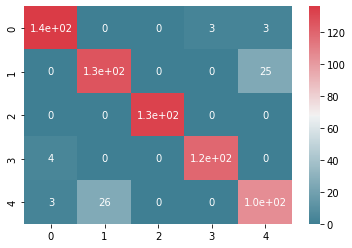

In [161]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
print('\n')
sns.heatmap(conf_matrix, cmap = cmap, annot=True)

## Классификаторы из sklearn

### GaussianNB

Замеры времени работы Гауссовского классификатора<br/>
Подсчет точности классификатора

In [162]:
time_gaussian = []
for iter in range(num_iterations):  
  start = time.time()
  model_gaussian = GaussianNB()
  model_gaussian.fit(X_train, y_train)
  pred_gaussian = model_gaussian.predict(X_test)
  time_gaussian.append(float(time.time() - start))
score = accuracy_score(y_test, pred_gaussian)
accuracy.at['gaussianNB', 'accuracy'] = score * 100

Матрица ошибок Гауссовского классификатора

[[136   0   0   3   3]
 [  0 126   0   0  25]
 [  0   0 133   0   0]
 [  4   0   0 119   0]
 [  3  26   0   0 105]]




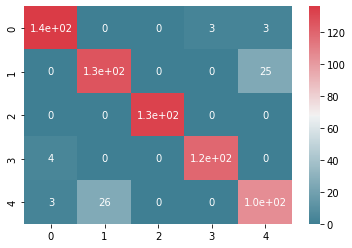

In [163]:
conf_matrix = confusion_matrix(y_test, pred_gaussian)
print(conf_matrix)
print('\n')
sns.heatmap(conf_matrix, cmap = cmap, annot=True)

### Подготовка данных

Произведем нормализацию, так как последующие классификаторы не работают с отрицательными значениями

In [164]:
scaler = MinMaxScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### MultinomialNB

Замеры времени работы Байсовского классификатора с полиномальной моделью<br/>
Подсчет точности классификатора

In [165]:
time_multinomail = []
for iter in range(num_iterations):
  start = time.time()
  model_multinomail = MultinomialNB()
  model_multinomail.fit(X_train_scaled, y_train)
  pred_multinomail = model_multinomail.predict(X_test_scaled)
  time_multinomail.append(float(time.time() - start))
score = accuracy_score(y_test,  pred_multinomail)
accuracy.at['multinomailNB', 'accuracy'] = score * 100

Матрица ошибок Байсовского классификатора с полиномальной моделью

[[ 75   0   0  44  23]
 [  0   0 129   0  22]
 [  0   0  89   7  37]
 [  0   0   0 123   0]
 [  1   0  31   0 102]]




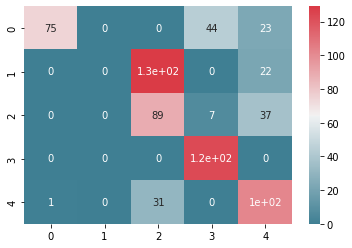

In [166]:
conf_matrix = confusion_matrix(y_test,  pred_multinomail)
print(conf_matrix)
print('\n')
sns.heatmap(conf_matrix, cmap = cmap, annot=True)

### ComplementNB

Замеры времени работы Байесовского классификатора использующего алгоритм дополнения.<br/>
Подсчет точности классификатора

In [167]:
# качество работы зависит от данных, ComplementNB, как правило, показывает лучший результат на несбалансированных данных 
# в нашем случае каждый класс имеет одинаковое количество элементов -> данные сбалансированны
time_complement = []
for iter in range(num_iterations):
  
  start = time.time()
  model_complement = ComplementNB()
  model_complement.fit(X_train_scaled, y_train)
  pred_complement = model_complement.predict(X_test_scaled)
  time_complement.append(float(time.time() - start))
score = accuracy_score(y_test,  pred_complement)
accuracy.at['complementNB', 'accuracy'] = score * 100

Матрица ошибок Байесовского классификатора использующего алгоритм дополнения.

[[  0   1   0 141   0]
 [  0 150   0   1   0]
 [  0 114   0  19   0]
 [  0   0   0 123   0]
 [  0 123   0  11   0]]




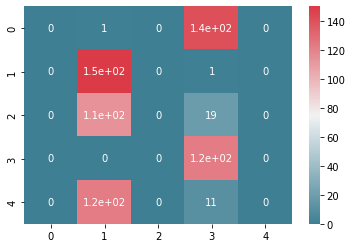

In [168]:
conf_matrix = confusion_matrix(y_test, pred_complement)
print(conf_matrix)
print('\n')
sns.heatmap(conf_matrix, cmap = cmap, annot=True)

### BernoulliNB

Замеры времени работы Байесовского классификатора для многомерных моделей Бернулли.<br/>
Подсчет точности Байесовского классификатора для многомерных моделей Бернулли.

In [170]:
# качество работы зависит от данных, BernoulliNB, как правило, показывает лучший результат на бинарных данных
time_bernoulli = []
for iter in range(num_iterations):
  
  start = time.time()
  model_bernoulli = BernoulliNB()
  model_bernoulli.fit(X_train_scaled, y_train)
  pred_bernoulli = model_bernoulli.predict(X_test_scaled)
  time_bernoulli.append(float(time.time() - start))
score = accuracy_score(y_test,  pred_bernoulli)
accuracy.at['bernoulliNB', 'accuracy'] = score * 100

Матрица ошибок Байесовского классификатора для многомерных моделей Бернулли

[[  0   0   0 142   0]
 [  0   0   0 151   0]
 [  0   0   0 133   0]
 [  0   0   0 123   0]
 [  0   0   0 134   0]]




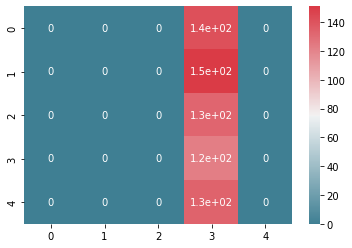

In [171]:
conf_matrix = confusion_matrix(y_test, pred_bernoulli)
print(conf_matrix)
print('\n')
sns.heatmap(conf_matrix, cmap = cmap, annot=True)

# Задание №2.<br/> Определить классификатор, имеющий наибольшую точность.

Для определения классификатора с максимальной точностью обратимся к таблице со значениями точности классификаторов.

In [172]:
quality = accuracy.accuracy.sort_values(ascending=False).to_frame()
quality

,accuracy
gaussianNB,90.6296
реализованный НБ,90.6296
multinomailNB,56.9546
complementNB,39.9707
bernoulliNB,18.0088


Построенные и Гауссовский калссификаторы показали одинаковую точность? Проверим это!

In [173]:
quality.accuracy[0] == quality.accuracy[1]

True

# Задание 3.<br/> Построение гистограммы производительности всех классификаторов на одном графике.

In [192]:
times = pd.DataFrame({
    'Реализация наивного байеса': time_NB,
    'gaussianNB': time_gaussian,
    'multinomailNB': time_multinomail,
    'bernoulliNB': time_bernoulli,
    'complementNB': time_complement
})
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Histogram(x=times['bernoulliNB'], name='bernouliNB'))
fig.add_trace(go.Histogram(x=times['gaussianNB'], name='gaussianNB'))
fig.add_trace(go.Histogram(x=times['multinomailNB'], name='multinomailNB'))
fig.add_trace(go.Histogram(x=times['complementNB'], name='complenetNB'))
fig.add_trace(go.Histogram(x=times['Реализация наивного байеса'], name='Реализация наивного байеса'))

fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show()

# Задание №4.<br/> Определить классификатор с наиболее стабильной производительностью.

In [193]:
# я хочу рассмотреть и выбрать лучший алгоритм в контексте разных разбиок train-test
# так как данные сбалансированны, то, скорее всего, наилучшую точность будут также обеспечивать реализованный наивный байес и gaussianNB

test_sizes = [.1, .15, .2, .25, .3, .35, .4, .45, .5, .55 ]
time_NB, time_gaussian, time_bernoulli, time_complement, time_multinomail = [], [], [], [], []
accuracy_NB, accuracy_gaussian, accuracy_bernoulli, accuracy_complement, accuracy_multinomail = [], [], [], [], []

for i, test_size in enumerate(test_sizes):
  X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['target_value']), data['target_value'], test_size = test_size, random_state=42)

  for iter in range(num_iterations):

    # собственная реализация наивного байеса
    start = time.time()
    model = NaiveBayesClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    time_NB.append(float(time.time() - start))
    score = accuracy_score(y_test, y_pred)
    accuracy_NB.append(score)

    # скилерн реализации
    start = time.time()
    model_gaussian = GaussianNB()
    model_gaussian.fit(X_train, y_train)
    pred_gaussian = model_gaussian.predict(X_test)
    time_gaussian.append(float(time.time() - start))
    score = accuracy_score(y_test, pred_gaussian)
    accuracy_gaussian.append(score)

    ## масштабирование признаков для решения проблемы с отрицательными числами
    scaler = MinMaxScaler()
    X_train_scaled= scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    start = time.time()
    model_multinomail = MultinomialNB()
    model_multinomail.fit(X_train_scaled, y_train)
    pred_multinomail = model_multinomail.predict(X_test_scaled)
    time_multinomail.append(float(time.time() - start))
    score = accuracy_score(y_test, pred_multinomail)
    accuracy_multinomail.append(score)

    start = time.time()
    model_complement = ComplementNB()
    model_complement.fit(X_train_scaled, y_train)
    pred_complement = model_complement.predict(X_test_scaled)
    time_complement.append(float(time.time() - start))
    score = accuracy_score(y_test, pred_complement)
    accuracy_complement.append(score)

    start = time.time()
    model_bernoulli = BernoulliNB()
    model_bernoulli.fit(X_train_scaled, y_train)
    pred_bernoulli = model_bernoulli.predict(X_test_scaled)
    time_bernoulli.append(float(time.time() - start))
    score = accuracy_score(y_test, pred_bernoulli)
    accuracy_bernoulli.append(score)

In [194]:
# графики время-точность для выбора лучшего и стабильного классификатора:

# датафреймы с результатами
results_NB = pd.DataFrame({'accuracy': accuracy_NB, 'time': time_NB})
results_gaussian = pd.DataFrame({'accuracy': accuracy_gaussian, 'time': time_gaussian})
results_multinomail = pd.DataFrame({'accuracy': accuracy_multinomail, 'time': time_multinomail})
results_complement = pd.DataFrame({'accuracy': accuracy_complement, 'time': time_complement})
results_bernoulli = pd.DataFrame({'accuracy': accuracy_bernoulli, 'time': time_bernoulli})

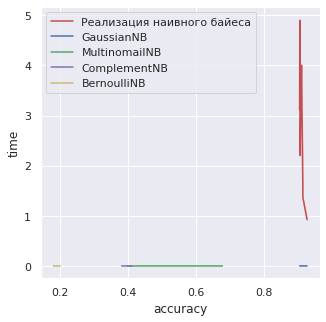

In [195]:
fig_dims = (5, 5)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(x = results_NB.accuracy, y=results_NB.time, data=results_NB,
             palette='pastel', color='r', label='Реализация наивного байеса')
sns.lineplot(x = results_gaussian.accuracy, y=results_gaussian.time, data=results_gaussian,
             palette='pastel', color='b', label='GaussianNB')
sns.lineplot(x = results_multinomail.accuracy, y=results_multinomail.time, data=results_multinomail,
             palette='pastel', color='g', label='MultinomailNB')
sns.lineplot(x = results_complement.accuracy, y=results_complement.time, data=results_complement,
             palette='pastel', color='m', label='ComplementNB')
sns.lineplot(x = results_bernoulli.accuracy, y=results_bernoulli.time, data=results_bernoulli,
             palette='pastel', color='y', label='BernoulliNB')

Ввиду огромной разницы во времени работы для стандартных алгоритмов из склилерна и собственной реализации байесовского классификатора график выглядит не очень информативным, однако точно можно сказать, что в разрезе точность/время:
-  лучший результат как у GaussianNB и у построенного классификатора, потому что он имеет маленький диапазон изменения точности и довольно быстрое исполнение.
-  худший результат даёт MultinomailNB, так как несмотря на быстрое испольнение, он имеет большой разброс в точности.
-  небольшой разброс в точности и быстрое выполнение есть у BernoulliNB и ComplementNB, но значения в диапазоне низкие, т.е. алгоритмы плохо справляются.

Таким образом можно утверждать, что собствееный построенный классификатора, как и GaussianNB из пактеа скилерн являются алгоритмами, обеспечивающим стабильную производительность в разрезе точность/время.

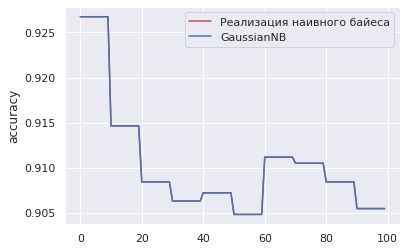

In [197]:
# только точность для алгоритмов, дающих наилучший результат точности

sns.lineplot(data=results_NB.accuracy,
             palette='pastel', color='r', label='Реализация наивного байеса')
sns.lineplot(data=results_gaussian.accuracy,
             palette='pastel', color='b', label='GaussianNB')

In [198]:
print('Реализация: ', results_NB.accuracy.mean())
print('Скилерн: ', results_gaussian.accuracy.mean())

Реализация:  0.910366315378474
Скилерн:  0.910366315378474


Видно, что точность у собственной реализации наивного байеса и наивного байеса из скилерн совпадает.

Таким образом, самую высокую точность обеспечивает как GaussianNB, так и собственная реализация.